# NLP - Amazon Musical Instruments Reviews

Com base no dataset Amazon Musical Instruments Reviews vou aplicar um Processamento de Linguagem Natural para poder avaliar as informações dos reviews dos usuários, objetivando relacionar e treinar a máquina para poder determinar a nota (overall) dada, conforme o 'reviewText' escrito pelo usuário.

In [42]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Carregar o dataset
df = pd.read_csv('Musical_instruments_reviews.csv')
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


## 1) Função de pré-processamento dos dados usando SpaCy, NLTK e/ou RegEx (lowercasing, remover pontuações, stopwords, lemmatize, etc);

A biblioteca NLTK (Natural Language Toolkit) será usada para remover as stopwords (palavras que não carregam informação), a SpaCy para a lematização (técnica de redução de palavras para sua forma base)

In [ ]:
#Instalando o modelo SpaCy en_core_web_sm
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install wordcloud==1.9.2


import nltk
nltk.download('stopwords')

In [4]:
import re #Biblioteca para trabalhar com Expressões regulares
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Carregando o modelo SpaCy
nlp = spacy.load('en_core_web_sm')

# Carregando stopwords do NLTK
nltk_stopwords = set(stopwords.words('english'))

## Pré-Processamento

Como as colunas 'reviewText' e 'summary' são a principal fonte de dados sobre a opinião dos usuários sobre o produto, iremos aplicar o PLN nelas para obter as informações necessárias.

In [16]:
# Substituir NaN por string vazia
df['reviewText'].fillna('', inplace=True)

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    
    # Remover pontuações
    text = re.sub(r'[^\w\s]', '', text)
    
    # Lematização e remoção de stopwords usando SpaCy e NLTK
    doc = nlp(text)
    tokens = []
    for token in doc:
        # Obtêm o lemma ("base ou raiz de uma palavra")
        lemma = token.lemma_
        
        # Verificar se o lemma está na lista de stopwords
        if lemma not in nltk_stopwords:
            # Senão adiciona à lista de tokens
            tokens.append(lemma)

    # Juntar os tokens em uma única string, separados por espaço
    processed_text = ' '.join(tokens)
    return processed_text

# Aplicando pré-processamento
def run_preprocess():
    df['processed_text'] = df['reviewText'].apply(preprocess_text)
    df['processed_summary'] = df['summary'].apply(preprocess_text)

run_preprocess()

In [17]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,processed_text,processed_summary
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014",much write exactly suppose filter pop sound re...,good
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013",product exactly quite affordablei realize doub...,jake
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013",primary job device block breath would otherwis...,job well
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014",nice windscreen protect mxl mic prevent pop th...,good windscreen money
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014",pop filter great look perform like studio filt...,pop I record vocal


## Tokenização usando Bag-of-Words (BOW)

O modelo Bag-of-Words (BOW), basicamente, representa um texto como um saco (ou multiset) de palavras, desconsiderando a gramática e a ordem das palavras, mas mantendo a multiplicidade. Em um modelo BOW, cada palavra no documento se torna uma característica no espaço de recursos.

In [24]:
def bag_of_words():
    # Ajustar e transformar os textos pré-processados
    global bow_matrix
    bow_matrix = count_vectorizer.fit_transform(df['processed_text'])

bag_of_words()

In [25]:
print("Quantidade de Features (palavras únicas):", bow_matrix.shape[0])

Quantidade de Features (palavras únicas): 10261


In [26]:
count_vectorizer = CountVectorizer()
bow_matrix = count_vectorizer.fit_transform(df['processed_text'])


print('#10 palavras mais frequentes')
sum_words = bow_matrix.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
print(words_freq[:10])


#10 palavras mais frequentes
[('use', 6993), ('guitar', 6584), ('sound', 4942), ('one', 4755), ('well', 4744), ('good', 4559), ('string', 4533), ('get', 4410), ('like', 4091), ('great', 4034)]


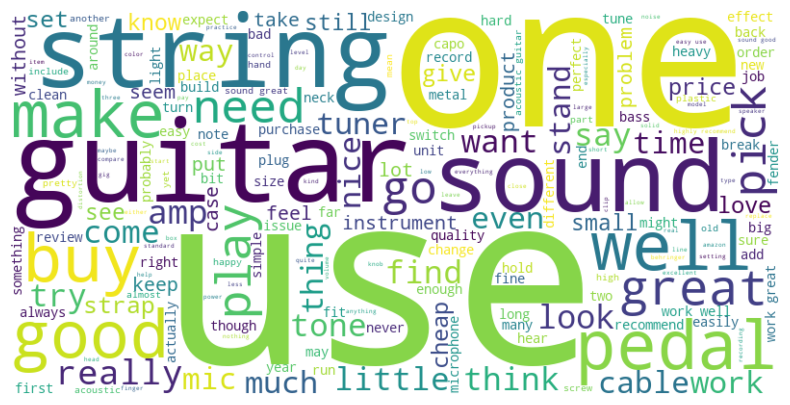

In [30]:
def creat_wordcloud(data):
    # Gerar a nuvem de palavras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(data)

    # Plotar a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
# Concatenar todos os textos processados em uma única string
concatenated_text = ' '.join(df['processed_text'])
creat_wordcloud(concatenated_text)


Como podemos observar pela nuvem de palavras, as palavras USE, e ONE se repetem muito e não tem valor semântico significativo. Por isso vou considerá-las como Stopwords.

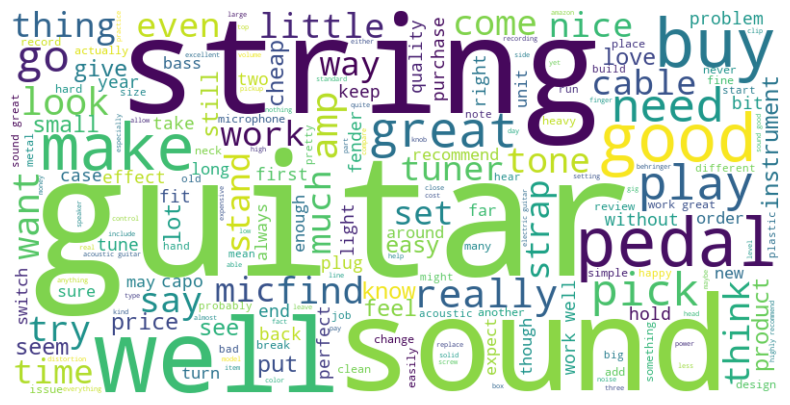

In [32]:
nltk_stopwords.add('one')
nltk_stopwords.add('use')

#Rodando novamete
run_preprocess()
bag_of_words()
concatenated_text = ' '.join(df['processed_text'])
creat_wordcloud(concatenated_text)

## Tokenização usando Term Frequency-Inverse Document Frequency (TF-IDF)

TF-IDF é uma medida estatística que ajuda a avaliar a importância de uma palavra em um documento, dentro de uma coleção de documentos (corpus). A ideia é que palavras que aparecem frequentemente em um documento, mas não em muitos documentos, são importantes. 

In [33]:
# Inicializar o TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Ajustar e transformar os textos pré-processados
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])

In [34]:
print("Quantidade de Features (palavras únicas):", tfidf_matrix.shape[0])

Quantidade de Features (palavras únicas): 10261


In [35]:
feature_names = tfidf_vectorizer.get_feature_names_out()
for doc_idx, doc in enumerate(tfidf_matrix.toarray()[:5]):  # Limitando para os primeiros 5 documentos
    print(f"Top terms in document {doc_idx}")
    top_terms = [feature_names[i] for i in doc.argsort()[:-5:-1]]  # Obtendo os 4 termos mais importantes
    print(top_terms)

Top terms in document 0
['filter', 'pop', 'pricing', 'despite']
Top terms in document 1
['smell', 'screen', 'filter', 'pop']
Top terms in document 2
['block', 'voice', 'attache', 'coax']
Top terms in document 3
['positioning', 'marginally', 'sag', 'mxl']
Top terms in document 4
['filter', 'pop', 'record', 'gets']


In [36]:
# Carregar o dataset novamente
df = pd.read_csv("Musical_instruments_reviews.csv")

# Substituindo NaN por string vazia
df['reviewText'].fillna("", inplace=True)

# Categorizando as avaliações como 'positive' ou 'negative'
df['label'] = df['overall'].apply(lambda x: 'positive' if x >= 4 else 'negative')

# Extração de recursos usando TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['reviewText'])
y = df['label']

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Naive Bayes
nb_classifier = MultinomialNB() #Classificador de frequências de termos
nb_classifier.fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)

# Avaliação do Naive Bayes
print("Naive Bayes Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb, zero_division=1))


Naive Bayes Classifier
Accuracy: 0.8811495372625426
              precision    recall  f1-score   support

    negative       1.00      0.00      0.00       244
    positive       0.88      1.00      0.94      1809

    accuracy                           0.88      2053
   macro avg       0.94      0.50      0.47      2053
weighted avg       0.90      0.88      0.83      2053



In [37]:
# SVM
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)

# Avaliação do SVM
print("SVM Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Classifier
Accuracy: 0.8835849975645397
              precision    recall  f1-score   support

    negative       1.00      0.02      0.04       244
    positive       0.88      1.00      0.94      1809

    accuracy                           0.88      2053
   macro avg       0.94      0.51      0.49      2053
weighted avg       0.90      0.88      0.83      2053



## Tokenização com TensorFlow

In [ ]:
!pip install tensorflow
#Utilizar apenas a CPU para virtualizar no Deepnote
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [39]:
# 1. Carregar o conjunto de dados
df = pd.read_csv('Musical_instruments_reviews.csv')

# 2. Pré-processamento de texto
# Substituir NaN por string vazia
df['reviewText'].fillna('', inplace=True)

# 3. Tokenização
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['reviewText'])

# 4. Transformar em Sequências
sequences = tokenizer.texts_to_sequences(df['reviewText'])

# Visualizar algumas sequências para verificação (primeiros 5)
print(sequences[:5])

[[20, 71, 6, 1794, 66, 288, 18, 7, 84, 394, 65, 39, 707, 6, 2161, 47, 2, 638, 120, 108, 12, 1026, 21, 71, 44, 1292, 7, 8, 26, 9, 2, 2339, 1473, 638, 2161, 13, 270, 24, 264, 22, 43, 103, 7, 25, 1076, 102, 2, 162, 1364, 188, 3282], [2, 118, 84, 394, 22, 7, 179, 5, 8, 253, 855, 4, 178, 20, 1723, 7, 32, 866, 1, 497, 7, 639, 24, 7, 32, 98, 82, 56, 4, 70, 501, 22, 48, 889, 1550, 26, 9, 2, 3164, 4441, 3, 148, 2402, 9, 2, 1551, 9, 48, 263, 1, 3669, 4, 78, 6, 103, 24, 10, 1, 4442, 4, 703, 1039, 816, 2, 638, 682, 488, 6, 12, 3535, 5, 1, 7, 122, 231, 1, 16, 239, 3, 638, 682, 11, 49, 102, 37, 22, 43, 22, 2, 272, 319, 5, 7, 209, 98, 261, 15, 3, 2882, 1, 33, 356, 178, 103, 11, 118], [2, 1835, 225, 9, 11, 430, 8, 6, 1655, 2, 4443, 14, 58, 852, 1254, 3, 2572, 38, 145, 2034, 46, 716, 6, 1608, 208, 15, 59, 1119, 3536, 9, 216, 29, 186, 1861, 2, 866, 626, 682, 3283, 2, 1862, 5, 1632, 2, 716, 208, 15, 59, 3670, 2, 205, 785, 556, 2340, 6, 2, 1031, 94, 834, 147, 6, 185, 7, 988, 2, 3284, 232, 454, 3, 69, 1, 6

In [40]:
# Interpretando os tokens usando um dicionário
word_index = tokenizer.word_index

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Função para converter sequências para texto
def sequence_to_text(sequence):
    return ' '.join([reverse_word_index.get(i, '?') for i in sequence])

example_sequence = sequences[0]
decoded_text = sequence_to_text(example_sequence)

print(f"Original Sequence: {example_sequence}")
print(f"Decoded Text: {decoded_text}")


Original Sequence: [20, 71, 6, 1794, 66, 288, 18, 7, 84, 394, 65, 39, 707, 6, 2161, 47, 2, 638, 120, 108, 12, 1026, 21, 71, 44, 1292, 7, 8, 26, 9, 2, 2339, 1473, 638, 2161, 13, 270, 24, 264, 22, 43, 103, 7, 25, 1076, 102, 2, 162, 1364, 188, 3282]
Decoded Text: not much to write about here but it does exactly what it's supposed to filters out the pop sounds now my recordings are much more crisp it is one of the lowest prices pop filters on amazon so might as well buy it they honestly work the same despite their pricing


## Treinando um modelo para interpretar os dados do PLN

O objetivo é que o modelo possa predizer a nota dada pelo cliente conforme o review escrito por ele.

In [47]:
# 1. Carregar o conjunto de dados novamente
df = pd.read_csv('Musical_instruments_reviews.csv')

# 2. Pré-processamento de texto
df['reviewText'].fillna('', inplace=True)

# 3. Tokenização
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['reviewText'])
sequences = tokenizer.texts_to_sequences(df['reviewText'])

# 4. Padding
padded_sequences = pad_sequences(sequences, padding='post')

# 5. Divisão do conjunto de dados
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['overall'], test_size=0.2, random_state=42)

# 6. Criação do modelo
model = Sequential([
    Embedding(input_dim=5000, output_dim=64),
    SimpleRNN(64),
    Dense(1, activation='linear')
])

# 7. Compilar e treinar o modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
257/257 [==============================] - 55s 212ms/step - loss: 1.2003 - mae: 0.7808 - val_loss: 0.8699 - val_mae: 0.7627
Epoch 2/10
257/257 [==============================] - 55s 214ms/step - loss: 0.7993 - mae: 0.6910 - val_loss: 0.8463 - val_mae: 0.6688
Epoch 3/10
257/257 [==============================] - 55s 214ms/step - loss: 0.8002 - mae: 0.6913 - val_loss: 0.8441 - val_mae: 0.7246
Epoch 4/10
257/257 [==============================] - 55s 214ms/step - loss: 0.7960 - mae: 0.6879 - val_loss: 0.8394 - val_mae: 0.7048
Epoch 5/10
257/257 [==============================] - 55s 215ms/step - loss: 0.7975 - mae: 0.6900 - val_loss: 0.8451 - val_mae: 0.6713
Epoch 6/10
257/257 [==============================] - 55s 216ms/step - loss: 0.7999 - mae: 0.6915 - val_loss: 0.8598 - val_mae: 0.6473
Epoch 7/10
257/257 [==============================] - 55s 214ms/step - loss: 0.7996 - mae: 0.6877 - val_loss: 0.8463 - val_mae: 0.7297
Epoch 8/10
257/257 [==============================] - 5

Potanto, podemos ver que foi obtido um Erro Médio Absoluto (MAE) bem alto, o que demonstra que o modelo precisa ser aprimorado. Contudo, nesse experimento foi possível entender que podemos a partir do processamento de linguagem natural e de machine learning entender a avaliação de um produto escrita por um usuário e prever a nota dada por ele. Uma estratégia muito interessante que é aplicada no dia a dia das empresas para melhorar estratégias de marketing e vendas.